# Assignment 4 - dimensionality reduction

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

### Name: Huang Kai
### UID: 3035086340

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [166]:
import pandas as pd
import numpy as np

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [167]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

print(X.shape)
num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

(178, 13)
training: 124, test: 54


In [168]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential forward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

In [169]:
%matplotlib inline
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [176]:
class SFS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1] #total number of features
        current_dim = 0 # current number of features
        self.indices_ = tuple() #at the beginning, empty
        self.subsets_ = []
        self.scores_=[] #at the beginning, empty

        while current_dim < self.k_features: #loop until current number of features reach the desired number
            scores = []
            subsets = []
            
            for p in range(dim): 
                if p not in self.indices_:
                    #compare the scores after adding every single feature not in the current set and choose the best
                    candidate = tuple([p])+self.indices_
                    score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, candidate)
                    scores.append(score)
                    subsets.append(candidate)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            current_dim += 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

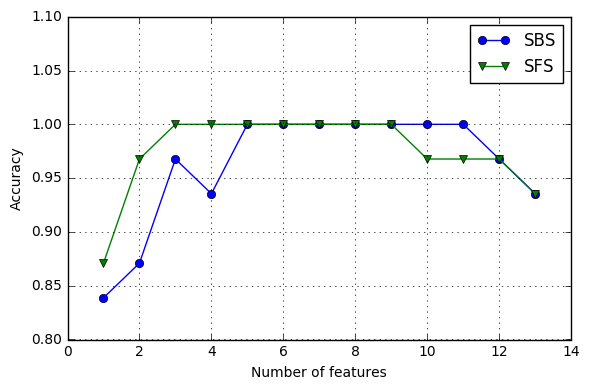

In [179]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

sfs = SFS(knn, k_features=13)
sfs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_sbs = [len(k) for k in sbs.subsets_]
k_feat_sfs = [len(k) for k in sfs.subsets_]

plt.plot(k_feat_1, sbs.scores_, marker='o', label='SBS')
plt.plot(k_feat_2, sfs.scores_, marker='v', label='SFS')
plt.ylim([0.8, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

### Observations
For SBS, k=5 to 11 are optimal with accuracy 1 while for SFS k=3 to 9 are optimal. Then we can see that SBS and SFS don't totally agree on the optimal number of features, but there is quite a large overlap.

The accuracy scores for some number of features vary when using SBS or SFS. For small number of features (eg. k=1 to 4 in this case), SFS performs much better than SBS. But for relatively large number of features (eg. k=10,11 in this case), SBS turns out to be more accurate.

When k isn't too large or too small (ie, in the middle), the two methods have compatible performance. This is because when getting to the middle, SBS has already eliminated several useless features and SFS has already added several useful features. The two methods reach a certain balance at this stage. Then the performance of them tend to be similar, both with satisfying accuracy. 

But say, for k=1, SFS works better when the dataset has a single feature that itself can make good classification. However, this useful feature may have been removed by SBS during previous iterations if it is not the best when combined with other features for classification. Say for k=10, since SFS adds features one at a time, it may ignore the impact of the combination of several features. In other words, the features that SFS choose to add in two iterations gives the best accuracy in its each iteration, but combining the two features may not perform as well as combining another two features. That may be the reason why for large k, SBS is better than SFS.

# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.

## Answer

### Description 1
PCA and LDA would produce very different results when taking class information into account makes the distribution of data within similar ranges quite unsymmetric and varied, especially when there is much overlap between features of different classes.

The example dataset generated by myself is plotted as follows. It consists of three classes, namely class 0,1,2. Each data sample has 2 features. Class 0 contains points on one logarithmic curve while class 1 contains points on three logarithmic curves. Class 3 contains just three vertical lines.

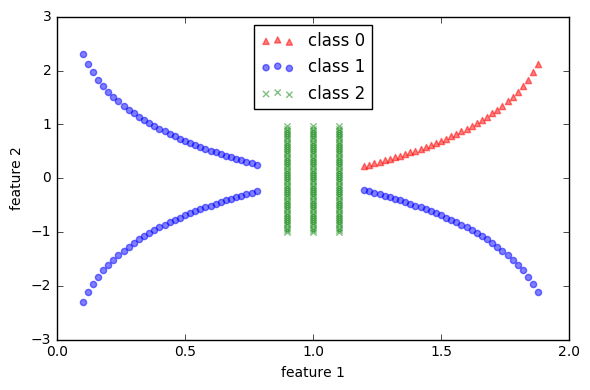

In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

class0 = [[0,x,-math.log(2-x)] for x in np.arange(1.2,1.9,0.02)]
class1 = [[1,x,math.log(x)] for x in np.arange(0.1,0.8,0.02)] + [[1,x,-math.log(x)] for x in np.arange(0.1,0.8,0.02)] + [[1,x,math.log(2-x)] for x in np.arange(1.2,1.9,0.02)] 
class2 = [[2,x,y] for x in np.arange(0.9,1.1,0.1) for y in np.arange(-1,1,0.04)]
dataset = np.array(class0+class1+class2)
X, y = dataset[:,1:3], dataset[:,0]

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5, label='class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5, label='class 1')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='green', marker='x', alpha=0.5, label='class 2')
plt.legend(loc='upper center')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.tight_layout()
plt.show()

### Description 2
When the above dataset is applied to PCA and LDA, I get the two graphs below. Obviously, the results are quite different.

For PCA, since we don't care of the class labels and the purpose is only to maximize the variances among the projected components, we get the two principle components are almost parallel to the horizontal and vertical axis. The four similar curves of class 0 and class 1 are treated equally in this case. The original vertical vector is treated as the first principle component because in the original dataset, the variance of feature 2 can lead to the maximum variance.

For LDA, besides the variance, we also need to take class information into consideration. Thus the curve of class 0 is treated differently from the three curves of class 1. This time our goal is to maximize inter-class variance and at the same time minimize intra-class variance. In the result of PCA, the variance within class1 is clearly not minimized, Thus, two vectors that are not parallel to the original axis are chosen as principle components to achieve this goal.

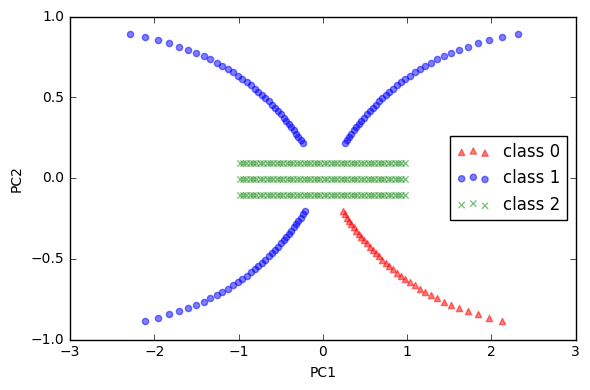

In [163]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_spca = pca.fit_transform(X)

plt.scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5, label='class 0')
plt.scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5, label='class 1')
plt.scatter(X_spca[y == 2, 0], X_spca[y == 2, 1], color='green', marker='x', alpha=0.5, label='class 2')
plt.legend(loc='center right')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [164]:
print(pca.components_)

[[ -8.91390353e-05   9.99999996e-01]
 [ -9.99999996e-01  -8.91390353e-05]]


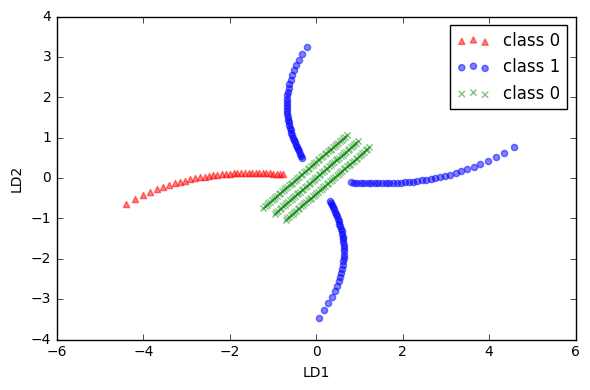

In [165]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X,y)

plt.scatter(X_lda[y == 0, 0], X_lda[y == 0, 1], color='red', marker='^', alpha=0.5, label='class 0')
plt.scatter(X_lda[y == 1, 0], X_lda[y == 1, 1], color='blue', marker='o', alpha=0.5, label='class 1')
plt.scatter(X_lda[y == 2, 0], X_lda[y == 2, 1], color='green', marker='x', alpha=0.5, label='class 0')
plt.legend(loc='upper right')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.tight_layout()
plt.show()